# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) December 2024

`CNModel` can also account for a full physical treatment of non-LTE effects. That is, it can model situations where the excitation temperature is *not* the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state column density is a free parameter, and the relative state column densities are set by the excitation temperature. Since there are more transitions than states, this is an overconstrained problem and no problem for a Bayesian forward model.

Hyperfine anomalies are treated as deviations in the *log Boltzmann factor*, $\ln B = -h\nu/(k_B T_{\rm ex})$, from the value determined by the mean cloud excitation temperature, `log_boltz_factor_mean`. The "spread" of log Boltzmann factor anomalies is inferred by the `log_boltz_factor_sigma` parameter. This is a modeling trick that allows us to constrain the hyperfine anomalies even if the cloud excitation tempearture is unconstrained (because the model is degenerate). Unless the mean cloud excitation temperature can be reliably determined by the line width (which requires (1) sufficient spectral resolution, (2) no non-thermal broadening, and (3) the LTE assumption that the mean cloud excitation temperature is equal to the cloud kinetic temperature), then allowing hyperfine anomalies means that the mean cloud excitation temperature will be impossible to constrain in the optically thin limit. Consequently, if the kinetic temperature cannot be reliably determined by the line width, then there is no way to constrain the kinetic temperature.

Note that while the mean cloud excitation temperature must be positive (since we specify the prior on the log excitation temperature), hyperfine anomalies can allow population inversions such that some transitions have *negative* excitation temperatures. This is a necessity since otherwise the parameter space becomes too confined for the MCMC sampler to efficiently explore. You should check that the model converges to a physically reasonable solution.

Furthermore, note that the hyperfine anomalies of unobserved transitions are unconstrained. Their posterior distributions will simply reflect the spread in possible log Boltzmann factors constrained by the observed transitions. We are essentially assuming that the hyperfine anomalies of unobserved transitions are similar to the hyperfine anomalies of the observed transitions.

With these considerations in mind, the best way to model hyperfine anomalies generally is to (1) NOT assume LTE, thus allowing the excitation temperature to differ from the kinetic temperature, (2) place a physically reasonable prior on the cloud mean excitation temperature, which will be difficult to constrain but will nonetheless propogate that uncertainty into the marginal posterior distributions, and (3) fix the kinetic temperature, which means that the thermal linewidth will be biased (fixed), but none of the other parameters will be biased (since nothing else depends on the kinetic temperature).

Here we demonstrate this in practice.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## Simulate data

Transition 113144.19 is constraining upper state 2 from lower state 1
Transition 113191.325 is constraining upper state 4 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 0 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 2
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[  15.84893192   63.09573445   79.43282347]
 [  15.84893192   63.09573445   79.43282347]
 [  15.84893631   63.0957519    79.43284544]
 [  15.84893192   63.09573445   79.43282347]
 [ 540.97644254   70.8891999  -203.68910831]
 [  10.6702437    59.80820671   54.28290536]
 [  15.8489379    63.09575824   79.43285343]
 [ 537.70824942   70.88757548 -203.82231669]
 

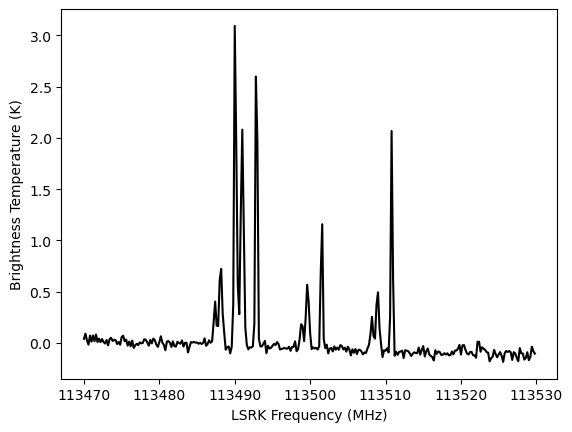

In [27]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(brightness_data)
observation._brightness_scale = observation.noise
dummy_data = {"observation": observation}

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = [1.75, 0.25], # mean and width of log10 mean cloud excitation temperature prior (K)
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log_boltz_factor_sigma = 0.1, # width of log Boltzmann factor hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# here we specify the normalized log boltzmann factor offset for simplicity
log_boltz_factor_free_norm = np.zeros((len(model.model.coords["transition_free"]), n_clouds))
log_boltz_factor_free_norm[3] = [-1.0, -0.25, -0.1]
log_boltz_factor_free_norm[4] = [2.0, 0.5, 0.3]

sim_params = {
    "log10_N0": [12.5, 12.2, 11.8],
    "log10_Tex_mean": [1.2, 1.8, 1.9],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [-2.0, -5.0, 8.0],
    "log_boltz_factor_free_norm": log_boltz_factor_free_norm,
}
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")
Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau_peak = model.model.tau_peak.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau_peak:")
print(tau_peak)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

## Model Definition

In [28]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(sim_brightness)
observation._brightness_scale = observation.noise
data = {"observation": observation}

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = [1.5, 0.2], # mean and width of log10 mean cloud excitation temperature prior (K)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log_boltz_factor_sigma = 0.1, # width of log Boltzmann factor hyperfine anomaly prior
    fix_log10_Tkin = 1.75, # assume a kinetic temperature = excitation temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 2 from lower state 1
Transition 113191.325 is constraining upper state 4 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 0 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 2
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


Sampling: [baseline_observation_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, observation, velocity_norm]


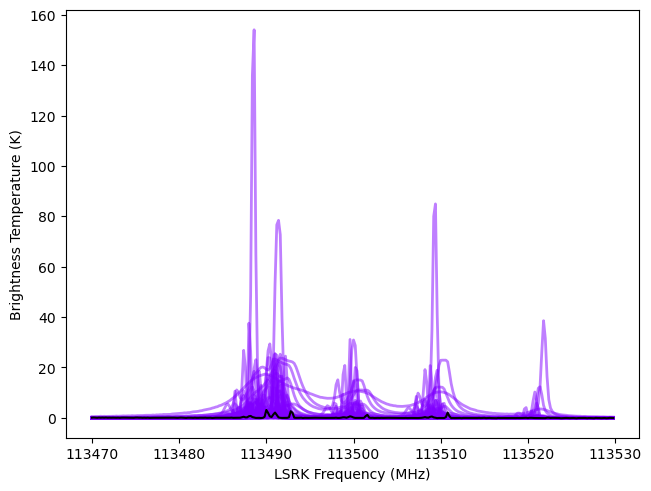

In [29]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [30]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 14500
Interrupted at 14,499 [14%]: Average Loss = 10,547
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1121 seconds.


Adding log-likelihood to trace


Output()

There were 26 divergences in converged chains.
Runtime: 20.28 minutes


In [31]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [observation]


Output()

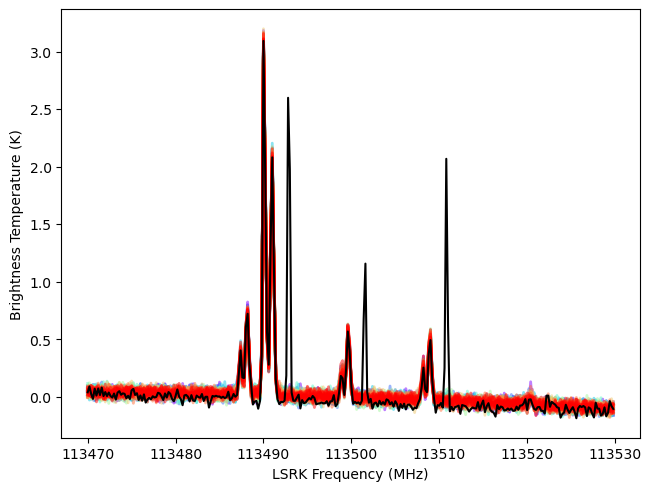

In [32]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)